# ¿Cuál es un mejor plan?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from scipy import stats as st

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Cargar los datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
calls = pd.read_csv('megaline_calls.csv')
inter = pd.read_csv('megaline_internet.csv')
msg = pd.read_csv('megaline_messages.csv')
plans = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users.csv')

## Preparar los datos

## Planes

In [3]:
# Imprime la información general/resumen sobre el DataFrame de los planes
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Imprime una muestra de los datos para los planes
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Los datos se encuentra correctos, al igual que el tipo de los mismos, al ser una tabla de solo dos filas no hay problema alguno al no tener valores ausentes, ya que nos explican los tipos de planes para cada uno, lo que si podemos agregar una columna con el numero de gigabytes de cada uno, ya veremos si es mas viable usar mb o gb en los pasos siguientes, de igua lforma cambiar los nombres de las columnas e incluir el "per_month" para evitar confusiones.

## Corregir los datos

In [5]:
plans = plans.rename(columns = {'messages_included' : 'messages_per_month_included',
                               'minutes_included':'minutes_per_month_included'})

In [6]:
plans.columns

Index(['messages_per_month_included', 'mb_per_month_included',
       'minutes_per_month_included', 'usd_monthly_pay', 'usd_per_gb',
       'usd_per_message', 'usd_per_minute', 'plan_name'],
      dtype='object')

## Enriquecer los datos

Agregaremos el valor de los megabytes incluidos pero en unidad de gigabytes

In [7]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024

In [8]:
plans.info()
plans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   messages_per_month_included  2 non-null      int64  
 1   mb_per_month_included        2 non-null      int64  
 2   minutes_per_month_included   2 non-null      int64  
 3   usd_monthly_pay              2 non-null      int64  
 4   usd_per_gb                   2 non-null      int64  
 5   usd_per_message              2 non-null      float64
 6   usd_per_minute               2 non-null      float64
 7   plan_name                    2 non-null      object 
 8   gb_per_month_included        2 non-null      float64
dtypes: float64(3), int64(5), object(1)
memory usage: 272.0+ bytes


,messages_per_month_included,mb_per_month_included,minutes_per_month_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Usuarios

In [9]:
# Imprime la información general/resumen sobre el DataFrame de los usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
# Imprime una muestra de los datos para los usuarios
users.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


* Tenemos la columna **reg_date** como object, la cambiaremos a datetime.\
* Tenemos la columna **churn_date** que tiene valores ausentes(significa que el plan aun sigue activo, llenaremos estos valores con '' (espacio) y posteriormente una columna **active_plan** que nos diga si/no el plan esta activo.\
* Una vez estos datos comprobaremos que no hay valores duplicados en la columna **user_id**
* Agregaremos una columna del mes,dia,año de registro **reg_month, reg_day, reg_year**
* Para futuras operaciones cambiaremos el nombre de la columna **plan** a **plan_name**



### Corregir datos

In [11]:
# correcion de reg_date
users['reg_date'] = pd.to_datetime(users['reg_date'],format = '%Y-%m-%d')

In [12]:
# correcion de reg_date
users = users.rename(columns = {'plan' : 'plan_name'})

In [13]:
#Rellenamos valores en churn_date
users['churn_date'] = users['churn_date'].fillna('2100-12-31')

In [14]:
# correcion de churn_date
users['churn_date'] = pd.to_datetime(users['churn_date'],format = '%Y-%m-%d')

In [15]:
#Comprobamos que no haya valores duplicados en la columna user_id
users[users['user_id'].duplicated()]

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date


In [16]:
# Comprobamos que lso datos estan correctos
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_name   500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enriquecer datos

In [17]:
#Creacion de columnas de fecha
users['reg_month'] = users['reg_date'].dt.month
users['reg_day'] = users['reg_date'].dt.weekday
users['reg_year'] = users['reg_date'].dt.year

In [18]:
#comprobamos que los valores esten correctos
users.info()

users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan_name   500 non-null    object        
 7   churn_date  500 non-null    datetime64[ns]
 8   reg_month   500 non-null    int64         
 9   reg_day     500 non-null    int64         
 10  reg_year    500 non-null    int64         
dtypes: datetime64[ns](2), int64(5), object(4)
memory usage: 43.1+ KB


,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date,reg_month,reg_day,reg_year
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2100-12-31,12,0,2018
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2100-12-31,8,0,2018
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2100-12-31,10,6,2018
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2100-12-31,1,6,2018
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2100-12-31,5,2,2018
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,2100-12-31,11,3,2018
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,11,1,2018
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,2100-12-31,7,2,2018
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,2100-12-31,8,4,2018
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,2100-12-31,4,6,2018


In [19]:
print('Contamos con',len(users['user_id'].unique()),'usuarios en la tabla users')

Contamos con 500 usuarios en la tabla users


## Llamadas

In [20]:
# Imprime la información/resumen general sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [21]:
# Imprime una muestra de datos para llamadas
calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


* Comprobamos que no tenemos valores ausentes.  
* Cambiaremos el tipo de datos de la columna **call_date** a datetime.  
* Agregaremos una columna de "duracion real" que tendra el dato de duracion de llamada redondeada como marcan los planes (un segundo redondea la llamada).
* Veremos cuantos usuarios han llamado
* Agregaremos una columna del mes,dia,año de llamada para posteriormente saber a que mes corresponden **call_month, call_day, call_year**

### Corregir datos

In [22]:
# correcion de call_date
calls['call_date'] = pd.to_datetime(calls['call_date'],format = '%Y-%m-%d')

### Enriquecer datos

In [23]:
# Agregamos la columna "duration_rounded" que nos da los minutos reales que se van a contabilizar de acuerdo a 
# la regla que un segundo redondea la llamada al siguiente minuto
def round_ceil(row):
    rounded = mt.ceil(row['duration'])
    return rounded

In [24]:
calls['duration_rounded'] = calls.apply(round_ceil,axis=1)

In [25]:
calls['call_month'] = calls['call_date'].dt.month
calls['call_day'] = calls['call_date'].dt.weekday
calls['call_year'] = calls['call_date'].dt.year

In [26]:
#Comprobamos que no haya valores duplicados en la columna id
calls[calls['id'].duplicated()]

,id,user_id,call_date,duration,duration_rounded,call_month,call_day,call_year


In [27]:
# Agregaremos a que plan pertenece cada usuario
calls = calls.merge(users[['user_id','plan_name']],on='user_id',how='left')

In [28]:
#comprobamos que los valores esten correctos
calls.info()

calls.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                137735 non-null  object        
 1   user_id           137735 non-null  int64         
 2   call_date         137735 non-null  datetime64[ns]
 3   duration          137735 non-null  float64       
 4   duration_rounded  137735 non-null  int64         
 5   call_month        137735 non-null  int64         
 6   call_day          137735 non-null  int64         
 7   call_year         137735 non-null  int64         
 8   plan_name         137735 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 10.5+ MB


,id,user_id,call_date,duration,duration_rounded,call_month,call_day,call_year,plan_name
0,1000_93,1000,2018-12-27,8.52,9,12,3,2018,ultimate
1,1000_145,1000,2018-12-27,13.66,14,12,3,2018,ultimate
2,1000_247,1000,2018-12-27,14.48,15,12,3,2018,ultimate
3,1000_309,1000,2018-12-28,5.76,6,12,4,2018,ultimate
4,1000_380,1000,2018-12-30,4.22,5,12,6,2018,ultimate
5,1000_388,1000,2018-12-31,2.20,3,12,0,2018,ultimate
6,1000_510,1000,2018-12-27,5.75,6,12,3,2018,ultimate
7,1000_521,1000,2018-12-28,14.18,15,12,4,2018,ultimate
8,1000_530,1000,2018-12-28,5.77,6,12,4,2018,ultimate
9,1000_544,1000,2018-12-26,4.40,5,12,2,2018,ultimate


In [29]:
print('Contamos con',len(calls['user_id'].unique()),'usuarios en la tabla calls')

Contamos con 481 usuarios en la tabla calls


In [30]:
#Verificamos que años se evaluan
calls['call_year'].unique()

array([2018], dtype=int64)

## Mensajes

In [31]:
# Imprime la información/resumen general sobre el DataFrame de los mensajes
msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [32]:
# Imprime una muestra de datos para los mensajes
msg.head(10)

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


* No tenemos valores ausentes  
* Convertiremos el tipo de valor de la columna **message_date** a datetime
* Veremos cuantos usuarios usan los mensajes
* Agregaremos una columna del mes,dia,año de mensajes para posteriormente saber a que mes corresponden **msg_month, msg_day, msg_year**

### Corregir datos

In [33]:
msg['message_date'] = pd.to_datetime(msg['message_date'],format='%Y-%m-%d')

### Enriquecer datos

In [34]:
# Agregamos las columnas de dia, mes, año
msg['msg_month'] = msg['message_date'].dt.month
msg['msg_day'] = msg['message_date'].dt.weekday
msg['msg_year'] = msg['message_date'].dt.year

In [35]:
#Comprobamos que no haya valores duplicados en la columna id
msg[msg['id'].duplicated()]

,id,user_id,message_date,msg_month,msg_day,msg_year


In [36]:
msg.info()

msg.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   msg_month     76051 non-null  int64         
 4   msg_day       76051 non-null  int64         
 5   msg_year      76051 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 3.5+ MB


,id,user_id,message_date,msg_month,msg_day,msg_year
0,1000_125,1000,2018-12-27,12,3,2018
1,1000_160,1000,2018-12-31,12,0,2018
2,1000_223,1000,2018-12-31,12,0,2018
3,1000_251,1000,2018-12-27,12,3,2018
4,1000_255,1000,2018-12-26,12,2,2018
5,1000_346,1000,2018-12-29,12,5,2018
6,1000_386,1000,2018-12-30,12,6,2018
7,1000_413,1000,2018-12-31,12,0,2018
8,1000_502,1000,2018-12-27,12,3,2018
9,1000_525,1000,2018-12-28,12,4,2018


In [37]:
print('Contamos con',len(msg['user_id'].unique()),'usuarios en la tabla msg')

Contamos con 402 usuarios en la tabla msg


In [38]:
#Verificamos que años se evaluan
msg['msg_year'].unique()

array([2018], dtype=int64)

## Internet

In [39]:
# Imprime la información/resumen general sobre el DataFrame de internet
inter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [40]:
# Imprime una muestra de datos para el tráfico de internet
inter.head(10)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


* Convertiremos el tipo de la columna **session_date** a datetime  
* Crearemos una columna **gb_used** con la columna **mb_used**.
*  Crearemos una columna de dia, mes y año para saber a que mes corresponde cada uso de datos.

### Corregir datos

In [41]:
inter['session_date'] = pd.to_datetime(inter['session_date'],format='%Y-%m-%d')

### Enriquecer datos

In [42]:
# Agregaremos las columnas de gb y las gb reales
inter['gb_used'] = inter['mb_used'] / 1024

In [43]:
# Agregaremos las columnas de dia, mes, año
inter['session_month'] = inter['session_date'].dt.month
inter['session_day'] = inter['session_date'].dt.weekday
inter['session_year'] = inter['session_date'].dt.year

In [44]:
# Agregaremos a que plan pertenece cada usuario
inter = inter.merge(users[['user_id','plan_name']],on='user_id',how='left')

In [45]:
#Comprobamos que no haya valores duplicados en la columna id
inter[inter['id'].duplicated()]

,id,user_id,session_date,mb_used,gb_used,session_month,session_day,session_year,plan_name


In [46]:
# Verificamos resultados
inter.info()
inter.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             104825 non-null  object        
 1   user_id        104825 non-null  int64         
 2   session_date   104825 non-null  datetime64[ns]
 3   mb_used        104825 non-null  float64       
 4   gb_used        104825 non-null  float64       
 5   session_month  104825 non-null  int64         
 6   session_day    104825 non-null  int64         
 7   session_year   104825 non-null  int64         
 8   plan_name      104825 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 8.0+ MB


,id,user_id,session_date,mb_used,gb_used,session_month,session_day,session_year,plan_name
0,1000_13,1000,2018-12-29,89.86,0.087754,12,5,2018,ultimate
1,1000_204,1000,2018-12-31,0.00,0.000000,12,0,2018,ultimate
2,1000_379,1000,2018-12-28,660.40,0.644922,12,4,2018,ultimate
3,1000_413,1000,2018-12-26,270.99,0.264639,12,2,2018,ultimate
4,1000_442,1000,2018-12-27,880.22,0.859590,12,3,2018,ultimate
5,1001_0,1001,2018-08-24,284.68,0.278008,8,4,2018,surf
6,1001_3,1001,2018-12-09,656.04,0.640664,12,6,2018,surf
7,1001_4,1001,2018-11-04,16.97,0.016572,11,6,2018,surf
8,1001_10,1001,2018-11-27,135.18,0.132012,11,1,2018,surf
9,1001_15,1001,2018-12-13,761.92,0.744062,12,3,2018,surf


In [47]:
print('Contamos con',len(inter['user_id'].unique()),'usuarios en la tabla inter')

Contamos con 489 usuarios en la tabla inter


In [48]:
#Verificamos que años se evaluan
inter['session_year'].unique()

array([2018], dtype=int64)

## Estudiar las condiciones del plan

In [49]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
plans

,messages_per_month_included,mb_per_month_included,minutes_per_month_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


In [50]:
calls.head()

,id,user_id,call_date,duration,duration_rounded,call_month,call_day,call_year,plan_name
0,1000_93,1000,2018-12-27,8.52,9,12,3,2018,ultimate
1,1000_145,1000,2018-12-27,13.66,14,12,3,2018,ultimate
2,1000_247,1000,2018-12-27,14.48,15,12,3,2018,ultimate
3,1000_309,1000,2018-12-28,5.76,6,12,4,2018,ultimate
4,1000_380,1000,2018-12-30,4.22,5,12,6,2018,ultimate


In [51]:
def column_rename(data,column,new_name):
    data = data.rename(columns = {column:new_name})
    return data

In [52]:
# Calcula el número y cantidad de llamadas hechas por cada usuario por mes. Guarda el resultado.
user_calls = calls.pivot_table(index=['user_id','call_month'],values='duration_rounded',aggfunc=('count','sum')).reset_index()
display(user_calls)

,user_id,call_month,count,sum
0,1000,12,16,124
1,1001,8,27,182
2,1001,9,49,315
3,1001,10,65,393
4,1001,11,64,426
...,...,...,...,...
2253,1498,12,39,339
2254,1499,9,41,346
2255,1499,10,53,385
2256,1499,11,45,308


In [53]:
# modificamos el nombre de la columna de mes
user_calls = column_rename(user_calls,'call_month','month')

In [54]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
user_msg = msg.pivot_table(index=['user_id','msg_month'],values='id',aggfunc='count').reset_index()
display(user_msg)

,user_id,msg_month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [55]:
# modificamos el nombre de la columna de mes
user_msg = column_rename(user_msg,'msg_month','month')

In [56]:
# Calcula el volumen del trafico de internet usado por cada usuario por mes. Guarda el resultado.
user_web = inter.pivot_table(index=['user_id','session_month'],values='gb_used',aggfunc=('sum')).reset_index()
display(user_web)

,user_id,session_month,gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605
...,...,...,...
2272,1498,12,22.595400
2273,1499,9,12.680430
2274,1499,10,19.035576
2275,1499,11,16.419756


In [57]:
# Redondeamos la tabla de uso de datos al numero mayor mas proximo de acuerdo a las condiciones del plan
user_web['gb_used'] = user_web['gb_used'].apply(np.ceil)

In [58]:
# Comprobamos que los datos se han modificado correctamente
user_web

,user_id,session_month,gb_used
0,1000,12,2.0
1,1001,8,7.0
2,1001,9,14.0
3,1001,10,22.0
4,1001,11,19.0
...,...,...,...
2272,1498,12,23.0
2273,1499,9,13.0
2274,1499,10,20.0
2275,1499,11,17.0


In [59]:
# modificamos el nombre de la columna de mes
user_web = column_rename(user_web,'session_month','month')

In [60]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan_name,churn_date,reg_month,reg_day,reg_year
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,2100-12-31,12,0,2018
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,2100-12-31,8,0,2018
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,2100-12-31,10,6,2018
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,2100-12-31,1,6,2018
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,2100-12-31,5,2,2018


In [61]:
# Combinamon los datos para las llamadas y mensajes con base en el user_id y el mes
plan_db = user_calls.merge(user_msg, on=['user_id','month'],how='outer')

In [62]:
# Combinamos los datos para el consumo de datos de internet con base en el user_id y el mes
plan_db = plan_db.merge(user_web, on=['user_id','month'],how='outer')

In [63]:
plan_db.head()

,user_id,month,count,sum,id,gb_used
0,1000,12,16.0,124.0,11.0,2.0
1,1001,8,27.0,182.0,30.0,7.0
2,1001,9,49.0,315.0,44.0,14.0
3,1001,10,65.0,393.0,53.0,22.0
4,1001,11,64.0,426.0,36.0,19.0


In [64]:
#Renombramos las columnas para mayor comprension data = data.rename(columns = {column:new_name})
plan_db = plan_db.rename(columns = {'count' : 'total_calls',
                                   'sum' : 'total_min',
                                   'id' : 'total_msg',
                                   'gb_used' : 'total_gb'})

In [65]:
# Añadimos la información de los usuarios
plan_db = plan_db.merge(users, on='user_id',how='right')

In [66]:
# Añade la información de los planes
plan_db = plan_db.merge(plans, on='plan_name',how='left')

In [67]:
# Rellenaremos los valores ausentes con 0
plan_db = plan_db.fillna(0)

In [68]:
plan_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      2303 non-null   int64         
 1   month                        2303 non-null   float64       
 2   total_calls                  2303 non-null   float64       
 3   total_min                    2303 non-null   float64       
 4   total_msg                    2303 non-null   float64       
 5   total_gb                     2303 non-null   float64       
 6   first_name                   2303 non-null   object        
 7   last_name                    2303 non-null   object        
 8   age                          2303 non-null   int64         
 9   city                         2303 non-null   object        
 10  reg_date                     2303 non-null   datetime64[ns]
 11  plan_name                    2303 non-null 

In [69]:
# Calcula el ingreso mensual para cada usuario
# Crearemos una situacion con el mes 12 que contiene mas datos
def over_min(row):
    if (row['total_min'] - row['minutes_per_month_included']) > 0:
        return row['total_min'] - row['minutes_per_month_included']
    else:
        return 0

def over_msg(row):
    if (row['total_msg'] - row['messages_per_month_included']) > 0:
        return row['total_msg'] - row['messages_per_month_included']
    else:
        return 0
    
def over_int(row):
    if (row['total_gb'] - row['gb_per_month_included']) > 0:
        return row['total_gb'] - row['gb_per_month_included']
    else:
        return 0  

In [70]:
#Creacion de columna con exceso de uso de minutos, mensaje y gb
plan_db['min_over'] = plan_db.apply(over_min,axis=1)
plan_db['msg_over'] = plan_db.apply(over_msg,axis=1)
plan_db['int_over'] = plan_db.apply(over_int,axis=1)

In [71]:
# Calcularemos el precio del exceso ocupado
plan_db['call_over_price'] = plan_db['min_over'] * plan_db['usd_per_minute']
plan_db['msg_over_price'] = plan_db['msg_over'] * plan_db['usd_per_message']
plan_db['int_over_price'] = plan_db['int_over'] * plan_db['usd_per_gb']

In [72]:
#Calcularemos el total a pagar
plan_db['to_pay'] = plan_db['call_over_price'] + plan_db['msg_over_price'] + plan_db['int_over_price'] + plan_db['usd_monthly_pay']

In [73]:
#Calcularemos el % de aumento si es que hay
plan_db['%'] = (plan_db['to_pay'] / plan_db['usd_monthly_pay'])

In [74]:
plan_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      2303 non-null   int64         
 1   month                        2303 non-null   float64       
 2   total_calls                  2303 non-null   float64       
 3   total_min                    2303 non-null   float64       
 4   total_msg                    2303 non-null   float64       
 5   total_gb                     2303 non-null   float64       
 6   first_name                   2303 non-null   object        
 7   last_name                    2303 non-null   object        
 8   age                          2303 non-null   int64         
 9   city                         2303 non-null   object        
 10  reg_date                     2303 non-null   datetime64[ns]
 11  plan_name                    2303 non-null 

## Estudia el comportamiento del usuario

### Llamadas

In [75]:
tr = plan_db

In [76]:
tr = tr.pivot_table(index=['plan_name','month'],
                       aggfunc='sum').reset_index()
tr.drop([0,13],axis=0,inplace=True)

In [77]:
tr['month'] = tr['month'].astype('int')

In [78]:
display(tr)

,plan_name,month,%,age,call_over_price,gb_per_month_included,int_over,int_over_price,mb_per_month_included,messages_per_month_included,...,to_pay,total_calls,total_gb,total_min,total_msg,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_id
1,surf,1,2.0000,105,0.00,30.0,0.0,0.0,30720,100,...,40.00,60.0,10.0,406.0,21.0,40,20,0.06,0.06,2404
2,surf,2,15.4785,430,9.33,135.0,12.0,120.0,138240,450,...,309.57,366.0,110.0,2673.0,108.0,180,90,0.27,0.27,11338
3,surf,3,52.8325,1109,16.26,345.0,58.0,580.0,353280,1150,...,1056.65,1068.0,312.0,7590.0,351.0,460,230,0.69,0.69,29228
4,surf,4,101.7765,2208,52.92,750.0,98.0,980.0,768000,2500,...,2035.53,2444.0,611.0,17577.0,870.0,1000,500,1.50,1.50,62439
5,surf,5,183.3685,3473,127.71,1155.0,199.0,1990.0,1182720,3850,...,3667.37,4289.0,1087.0,30768.0,1849.0,1540,770,2.31,2.31,95348
6,surf,6,238.9900,4306,155.31,1455.0,267.0,2670.0,1489920,4850,...,4779.80,5769.0,1502.0,41836.0,2454.0,1940,970,2.91,2.91,119822
7,surf,7,379.1780,5258,265.98,1815.0,488.0,4880.0,1858560,6050,...,7583.56,7642.0,2042.0,54448.0,3271.0,2420,1210,3.63,3.63,148939
8,surf,8,517.8425,7083,267.66,2430.0,682.0,6820.0,2488320,8100,...,10356.85,9325.0,2735.0,66438.0,4662.0,3240,1620,4.86,4.86,199675
9,surf,9,565.2335,8559,278.58,2910.0,711.0,7110.0,2979840,9700,...,11304.67,11273.0,3238.0,80360.0,5968.0,3880,1940,5.82,5.82,241472
10,surf,10,775.2415,10484,425.25,3555.0,1028.0,10280.0,3640320,11850,...,15504.83,14303.0,4126.0,101846.0,8020.0,4740,2370,7.11,7.11,295550


In [79]:
# Promedio de duracion de llamadas
tr['calls_mean'] = tr['total_min'] / tr['total_calls']

In [80]:
# Definimos las tablas con su respectivo plan para calculos generales
tr_surf = tr.query('plan_name == "surf"')
tr_ult = tr.query('plan_name == "ultimate"')

In [81]:
# Definimos las tablas con su respectivo plan para calculos por usuario
user_surf = plan_db.query('plan_name == "surf"')
user_ult = plan_db.query('plan_name == "ultimate"')

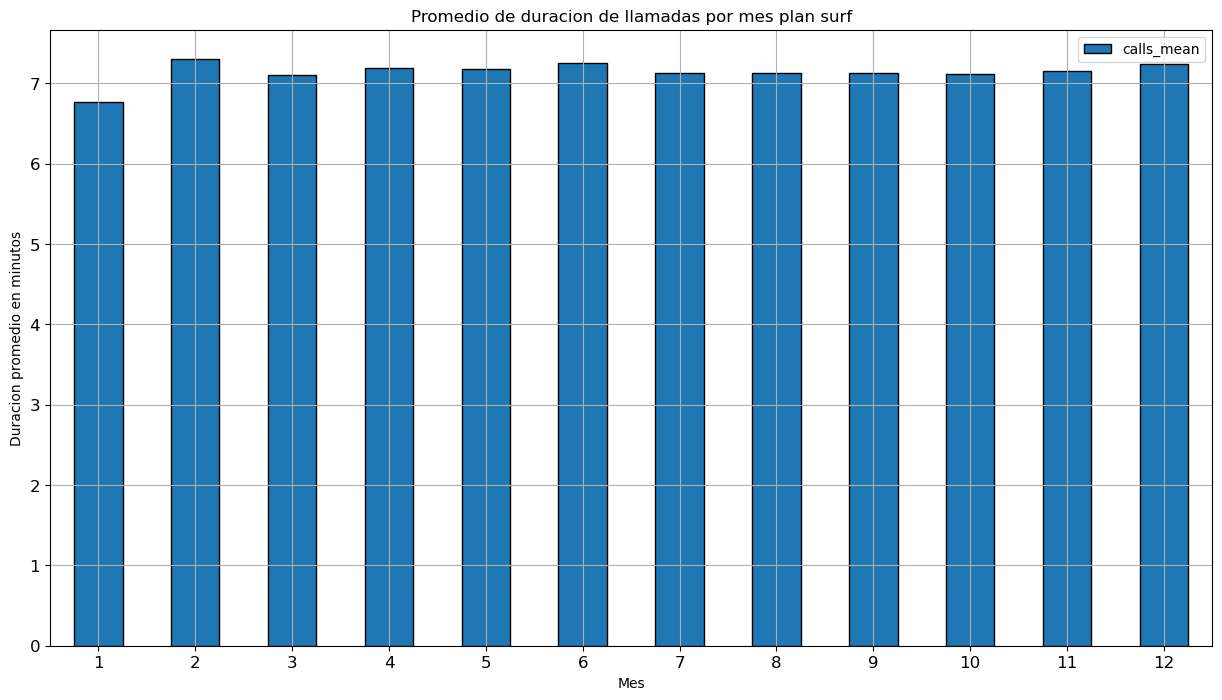

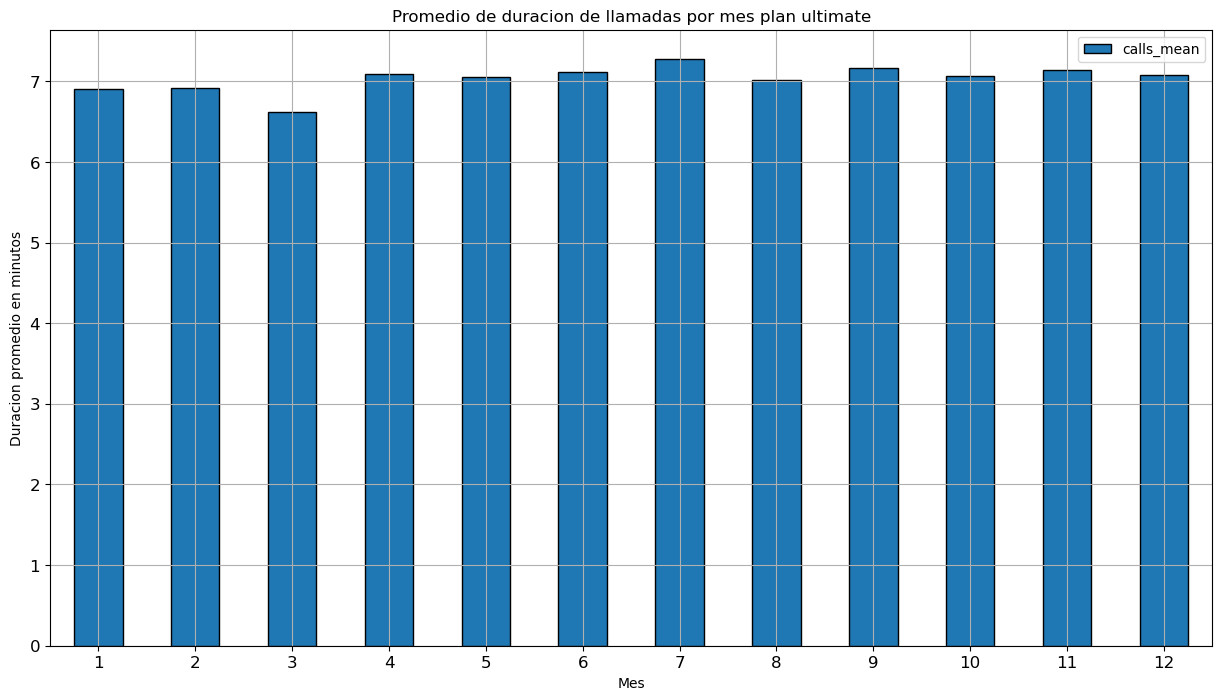

In [82]:
# Compara la duración promedio de llamadas por cada plan por cada mes. Dibuja una gráfica de barras para visualizarlo.
tr_surf.plot(x='month',
        y='calls_mean',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Promedio de duracion de llamadas por mes plan surf',
                                                ylabel='Duracion promedio en minutos',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
tr_ult.plot(x='month',
        y='calls_mean',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Promedio de duracion de llamadas por mes plan ultimate',
                                                ylabel='Duracion promedio en minutos',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
plt.show()

Podemos observar que el promedio de duracion de cada llamada en ambos planes rondan los 7 minutos

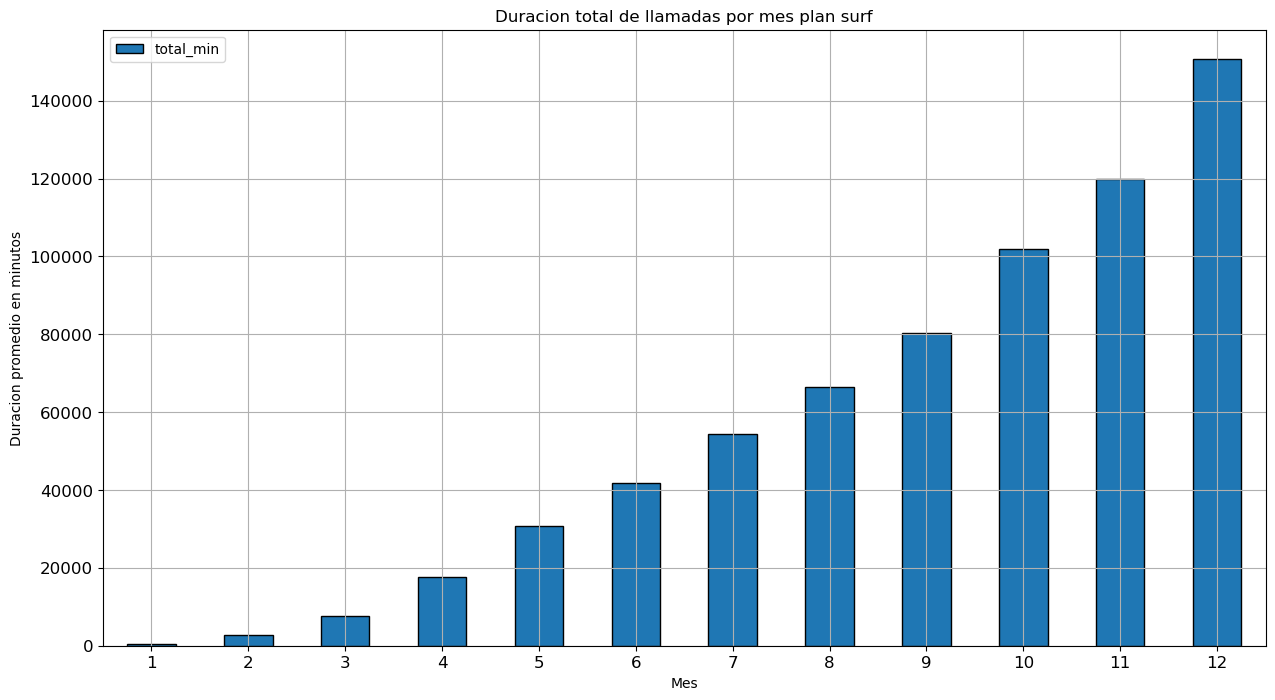

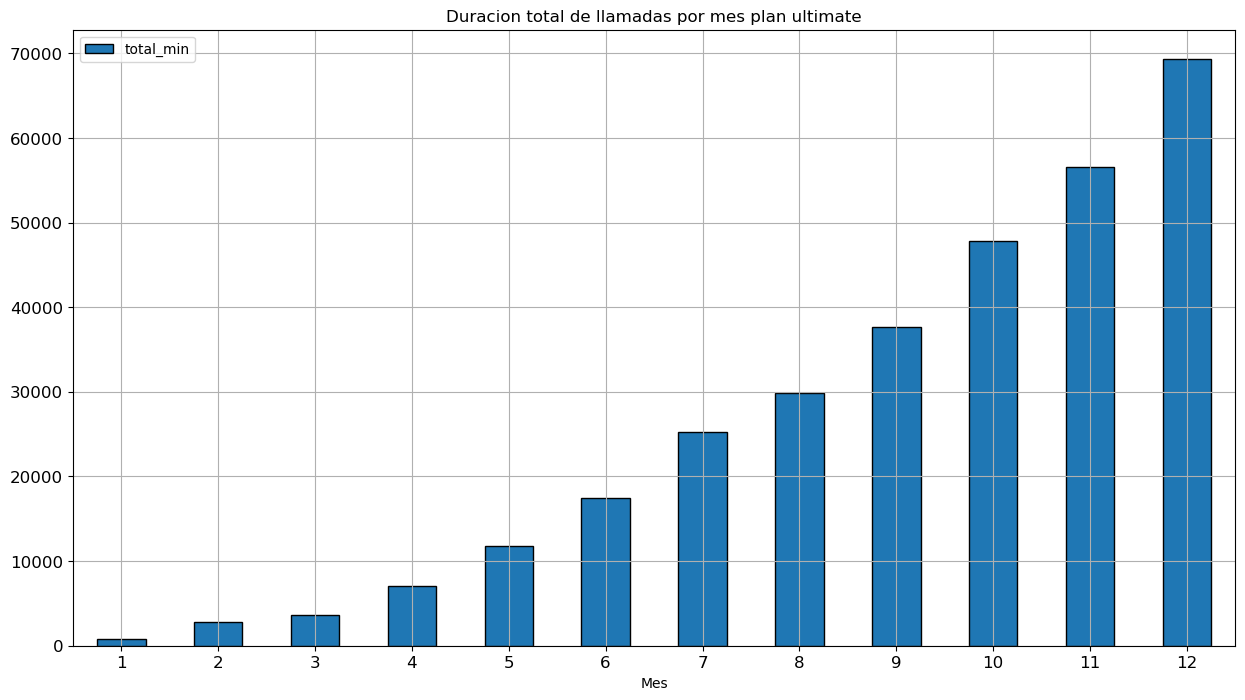

In [83]:
# Compara la duracion total de llamadas por cada plan por cada mes.
tr_surf.plot(x='month',
        y='total_min',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Duracion total de llamadas por mes plan surf',
                                                ylabel='Duracion promedio en minutos',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
tr_ult.plot(x='month',
        y='total_min',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Duracion total de llamadas por mes plan ultimate',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
plt.show()

Podemos observar que la duracion total de llamadas por mes es el doble aproximadamente en el plan surf en comparacion con el plan ultimate

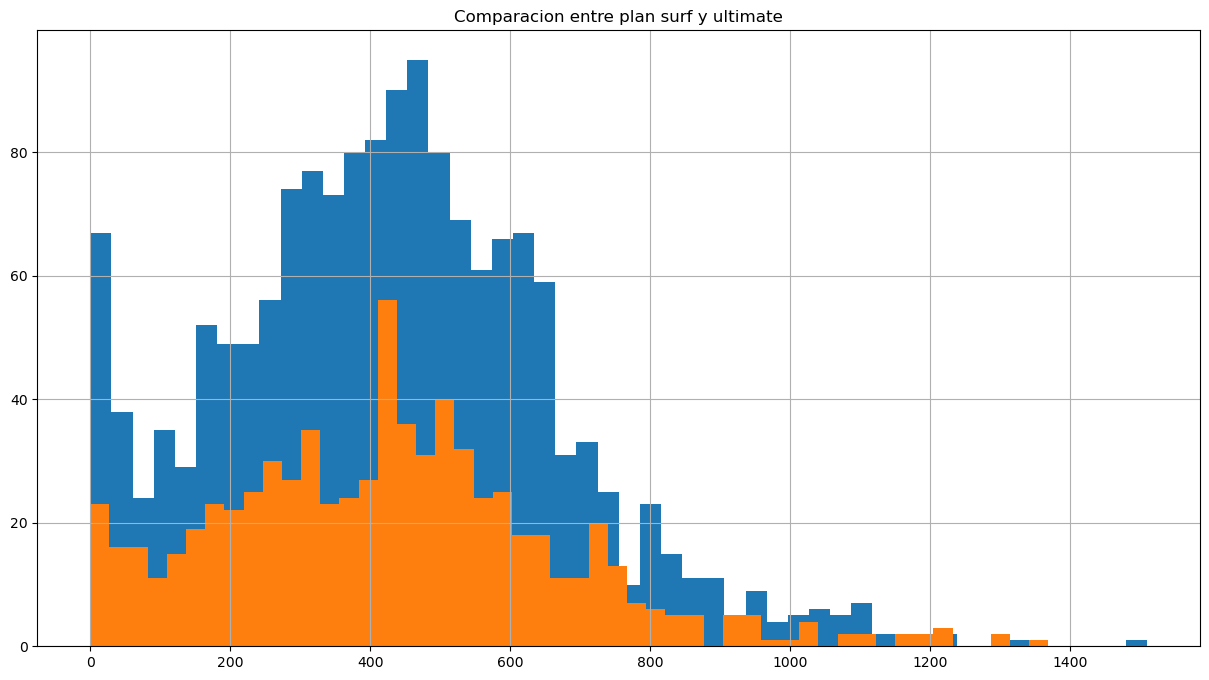

In [84]:
#Mostramos los histogramas superpuestos para ver la comparativa
user_surf['total_min'].hist(density=False,bins=50,figsize=(15,8))
user_ult['total_min'].hist(density=False,bins=50,figsize=(15,8))
plt.title('Comparacion entre plan surf y ultimate')
plt.show()

Como podemos observar tenemos una tendencia en ambos planes con **sesgo a la derecha o asimetria positiva**, 

In [85]:
# Datos generales de los minutos de ambos planes 
print(tr_surf['total_min'].describe())
print(tr_ult['total_min'].describe())

count        12.000000
mean      56201.916667
std       49020.029427
min         406.000000
25%       15080.250000
50%       48142.000000
75%       85731.500000
max      150680.000000
Name: total_min, dtype: float64
count       12.000000
mean     25827.000000
std      22846.433388
min        774.000000
25%       6218.250000
50%      21316.000000
75%      40164.000000
max      69324.000000
Name: total_min, dtype: float64


In [86]:
# Varianza de la duración total mensual de llamadas.
print('Varianza plan surf')
print(np.var(tr_surf['total_min']))
print()
print('Varianza plan ultimate')
print(np.var(tr_ult['total_min']))

Varianza plan surf
2202716344.5763893

Varianza plan ultimate
478462892.0


In [87]:
# Media y la varianza de la duración mensual de cada llamada por mes.
print('La varianza y el promedio de la duracion de las llamadas al mes por tipo de plan')
display(calls.pivot_table(index='call_month',values='duration_rounded',columns='plan_name',aggfunc=('var')))

La varianza y el promedio de la duracion de las llamadas al mes por tipo de plan


plan_name,surf,ultimate
call_month,,
1,28.995480,37.091055
2,36.381743,34.597461
3,33.656824,34.070435
4,34.754400,33.394424
5,35.962592,35.733997
6,36.481110,34.855589
7,34.794517,35.982694
8,35.277344,35.078787
9,36.022955,35.398330


Podemos observar que seria dificil describir a simple vista la asimetria del grafico en ambas partes, pero de acuerdo a los datos obtenidos, tenemos que la media es mayor a la mediana en ambas partes, por lo que tenemos un grafico **con asimetria positiva**.\
De igual forma podemos observar que la mayoria de usuarios llegan a usar de 400 a 500 minutos en ambos planes

Diagramas de caja para el plan surf


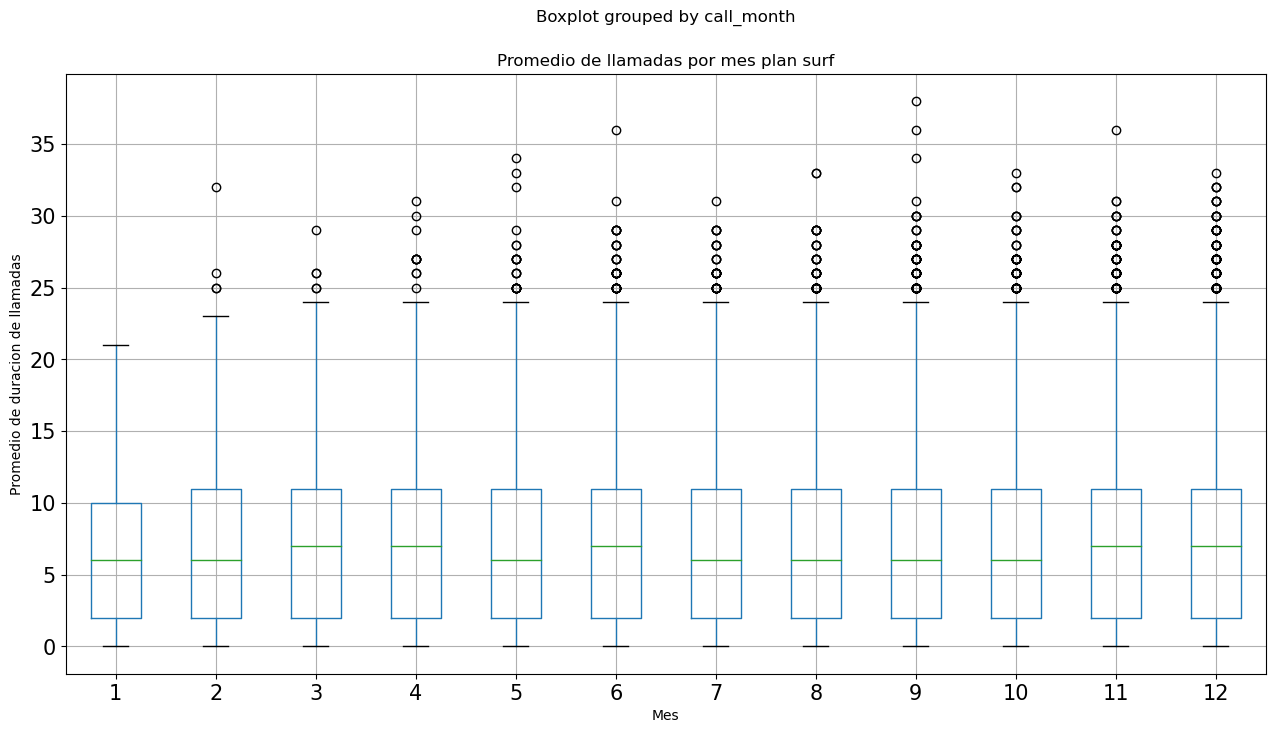

In [88]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas.
print('Diagramas de caja para el plan surf')
calls.query('plan_name == "surf"').boxplot(column='duration_rounded',by='call_month',figsize=(15,8),fontsize=15)
plt.title('Promedio de llamadas por mes plan surf')
plt.xlabel('Mes')
plt.ylabel('Promedio de duracion de llamadas')
plt.show()

Diagramas de caja para el plan ultimate


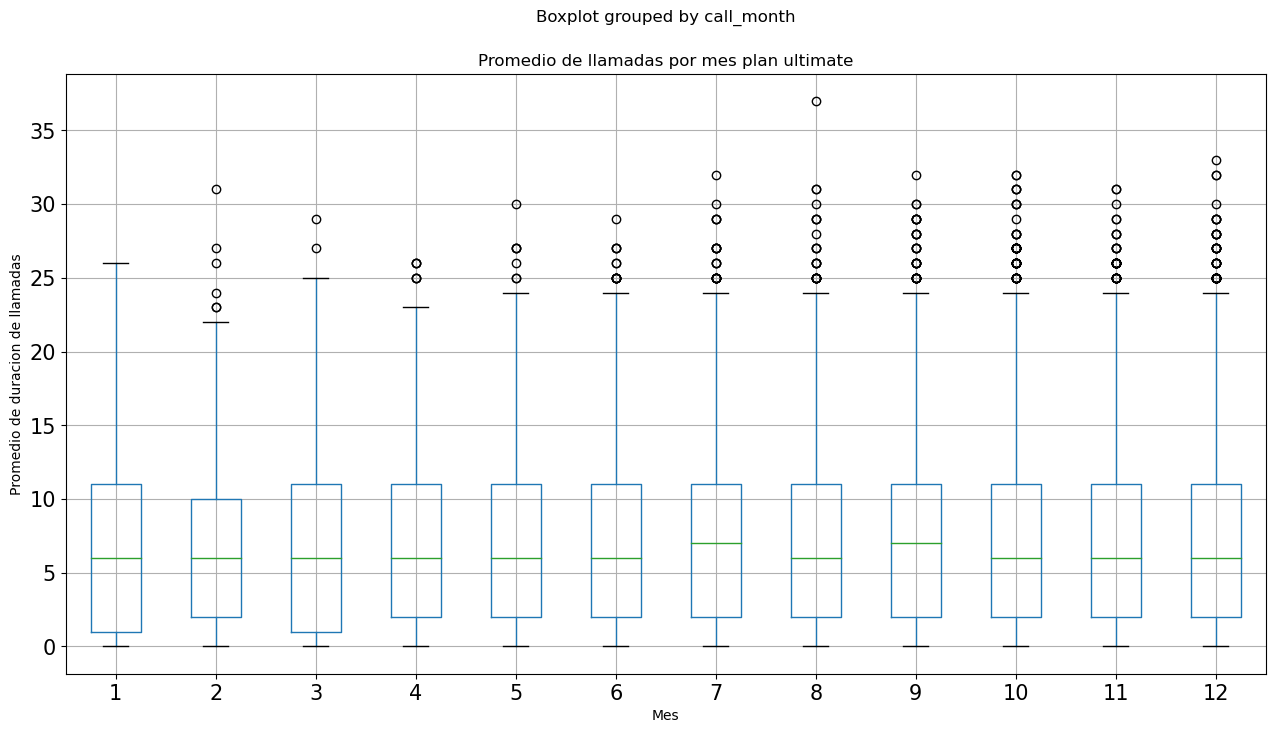

In [89]:
print('Diagramas de caja para el plan ultimate')
calls.query('plan_name == "ultimate"').boxplot(column='duration_rounded',by='call_month',figsize=(15,8),fontsize=15)
plt.title('Promedio de llamadas por mes plan ultimate')
plt.xlabel('Mes')
plt.ylabel('Promedio de duracion de llamadas')
plt.show()

De acuerdo al analisis en cuanto a llamadas, los usuario se comportan de manera muy similar, en cuanto a duracion de llamadas, podemos observar que la media de la duracion de las llamadas es alrededor de 7 min para ambos planes, siendo que rara vez tenemos llamadas con una duracion mayor o igual a 25 minutos; sin embargo, se tienen mas minutos utilizados por usuarios del plan surf de aproximadamente el doble.

### Mensajes

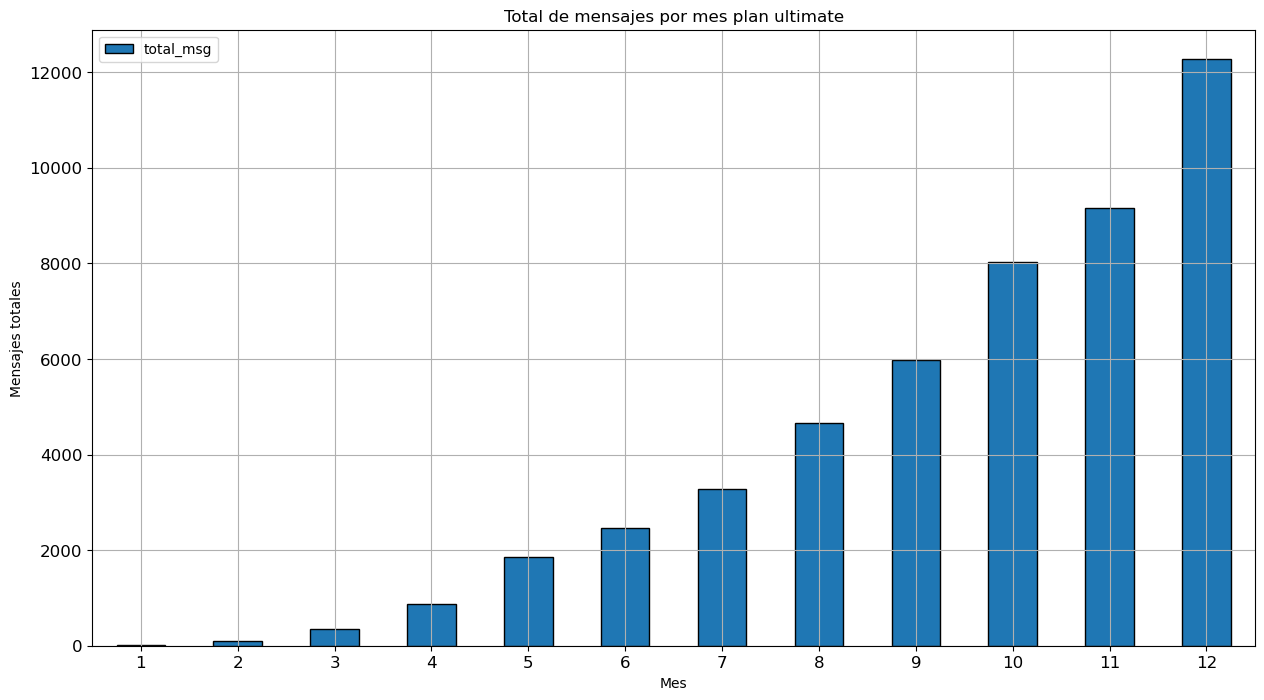

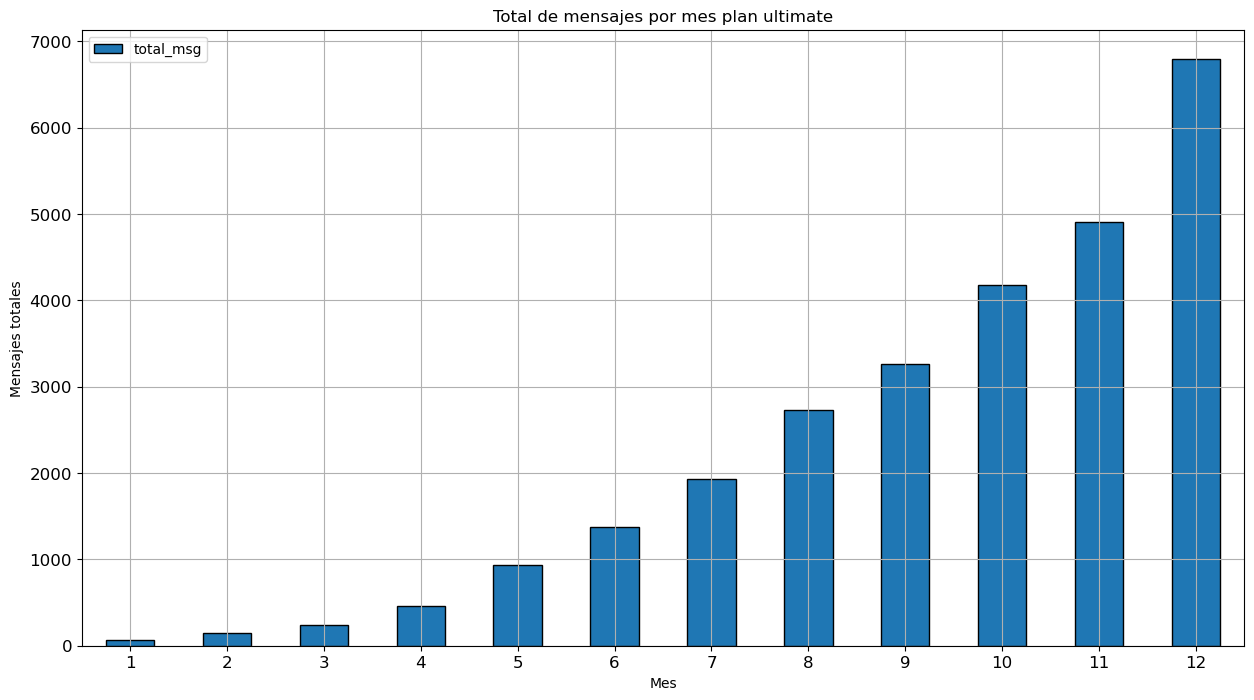

In [90]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
tr_surf.plot(x='month',
        y='total_msg',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Total de mensajes por mes plan ultimate',
                                                ylabel='Mensajes totales',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
tr_ult.plot(x='month',
        y='total_msg',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Total de mensajes por mes plan ultimate',
                                                ylabel='Mensajes totales',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
plt.show()

Como podemos observar a traves del analisis, se tiene un envio significativo y mayor de mensajes de los usuarios de los planes de surf en comparacion con los usuarios del plan ultimate, ya que apartir del mes 4(Abril), se tiene casi una proporcion 2:1 en cuanto numero de mensajes enviados entre planes, es decir, el doble de mensajes enviados por usuarios del plan Surf.

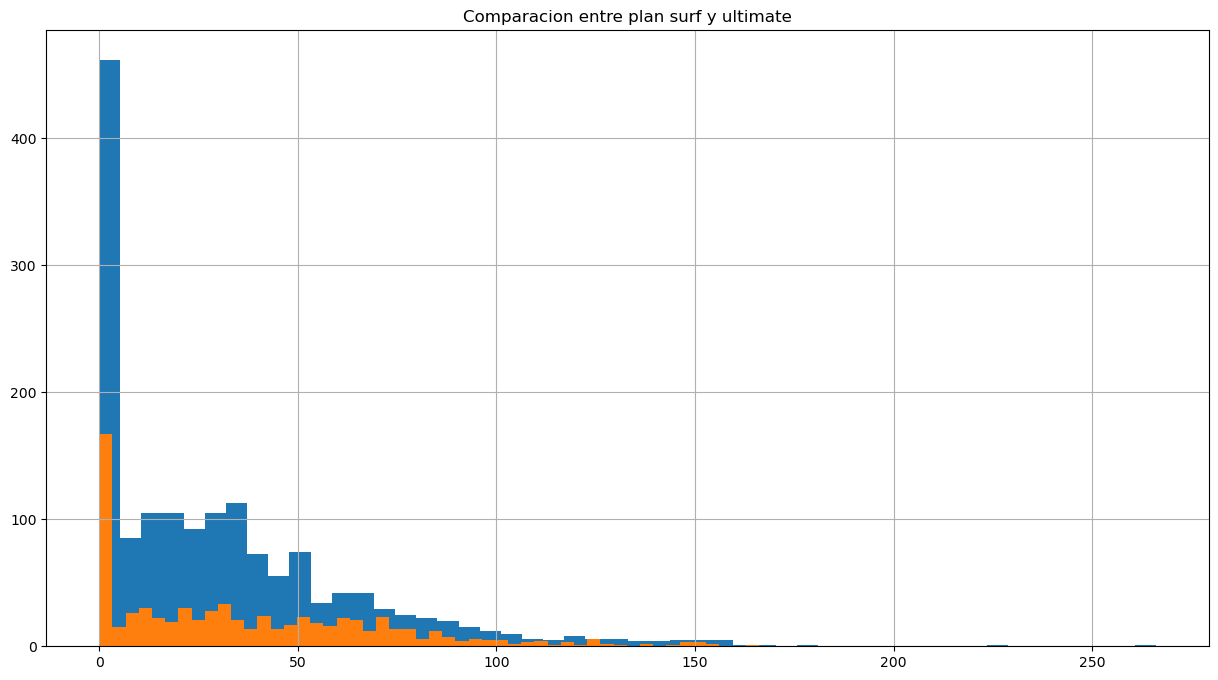

In [91]:
#Mostramos los histogramas superpuestos para ver la comparativa
user_surf['total_msg'].hist(density=False,bins=50,figsize=(15,8))
user_ult['total_msg'].hist(density=False,bins=50,figsize=(15,8))
plt.title('Comparacion entre plan surf y ultimate')
plt.show()

Como podemos observar tenemos una tendencia en ambos planes con **sesgo a la derecha o asimetria positiva**, en el histograma podemos ver valores cerca del 0, esto no quiere decir que no hayan mensajes, sino que, gran parte de los usuarios utiliza de 1 a 12 mensajes.

In [92]:
# Datos generales de los mensajes de ambos planes 
print(tr_surf['total_msg'].describe())
print(tr_ult['total_msg'].describe())

count       12.000000
mean      4084.500000
std       4013.379884
min         21.000000
25%        740.250000
50%       2862.500000
75%       6481.000000
max      12275.000000
Name: total_msg, dtype: float64
count      12.000000
mean     2253.083333
std      2167.833248
min        62.000000
25%       408.000000
50%      1658.000000
75%      3489.500000
max      6796.000000
Name: total_msg, dtype: float64


Como podemos observar tenemos una tendencia en ambos planes con **sesgo a la derecha o asimetria positiva** y podemos comprobarlo con los datos de la columna

In [93]:
# Varianza de la cantidad total mensual de mensajes.
print('Varianza plan surf')
print(np.var(tr_surf['total_msg']))
print()
print('Varianza plan ultimate')
print(np.var(tr_ult['total_msg']))

Varianza plan surf
14764949.916666666

Varianza plan ultimate
4307875.909722222


In [94]:
# Varianza de la cantidad de mensajes por mes y por plan.
print('La varianza y el promedio de la duracion de las llamadas al mes por tipo de plan')
display(plan_db.pivot_table(index='month',values='total_msg',columns='plan_name',aggfunc=('var','mean')))

La varianza y el promedio de la duracion de las llamadas al mes por tipo de plan


mean                     var             
plan_name       surf   ultimate         surf     ultimate
month                                                    
0.0         0.000000   0.000000     0.000000     0.000000
1.0        10.500000  15.500000   220.500000   313.666667
2.0        12.000000  21.571429   386.000000   478.285714
3.0        15.260870  20.250000   346.565217   654.386364
4.0        17.400000  22.047619   501.591837   544.147619
5.0        24.012987  32.103448   847.197198  1297.310345
6.0        25.298969  29.340426   914.920103   857.620722
7.0        27.033058  32.830508   923.915565   960.488019
8.0        28.777778  38.478873  1029.515528  1196.367404
9.0        30.762887  37.895349  1003.829496  1050.918331
10.0       33.839662  39.443396  1275.465708  1221.106289
11.0       32.385159  38.606299  1065.344034  1232.669166
12.0       38.600629  45.006623  1458.158612  1549.419956

### Internet

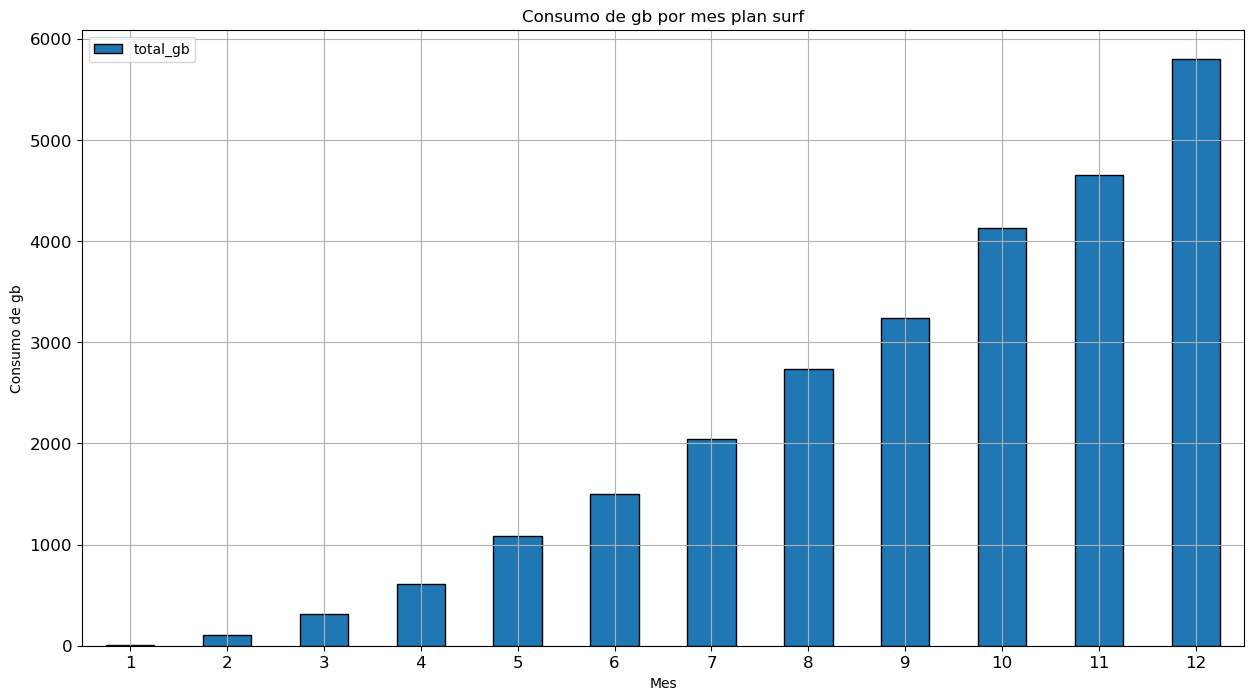

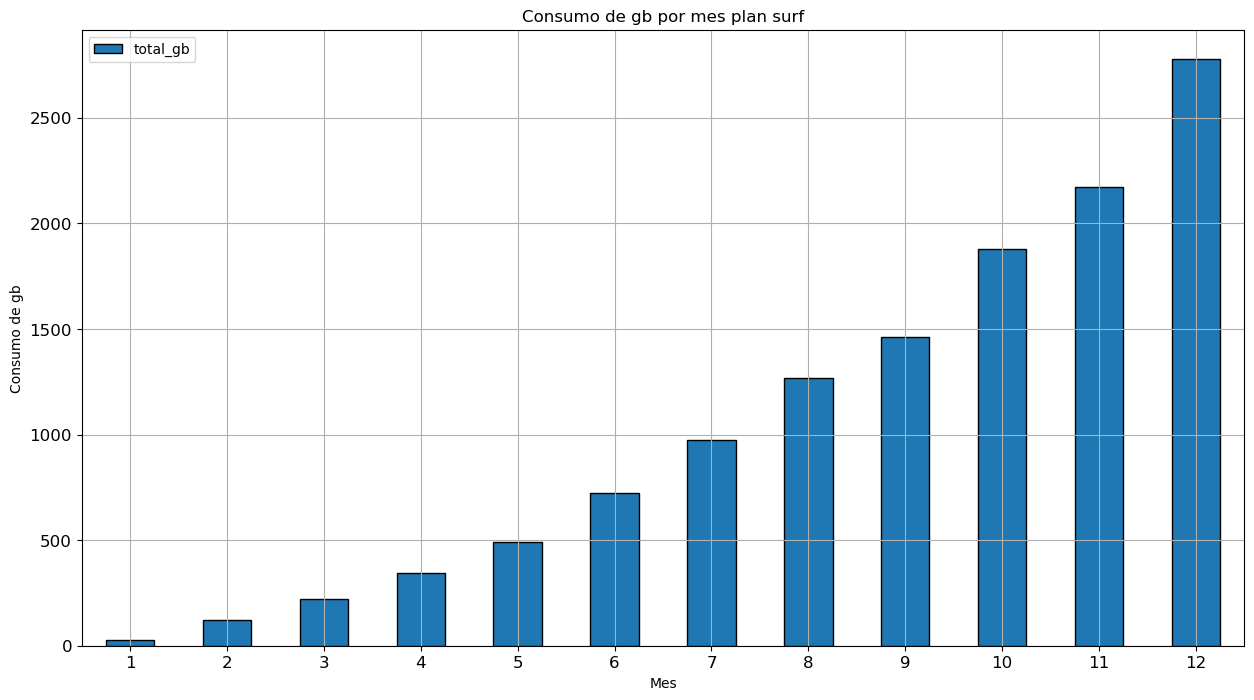

In [95]:
# Compara la cantidad de tráfico de internet consumido por usuarios por plan
tr_surf.plot(x='month',
        y='total_gb',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Consumo de gb por mes plan surf',
                                                ylabel='Consumo de gb',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
tr_ult.plot(x='month',
        y='total_gb',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Consumo de gb por mes plan surf',
                                                ylabel='Consumo de gb',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
plt.show()

Podemos observar que los usuarios de plan surf tienden a consumir el doble de gb que los usuarios del plan ultimate

Como podemos observar tenemos una tendencia en ambos planes con **sesgo a la derecha o asimetria positiva** 

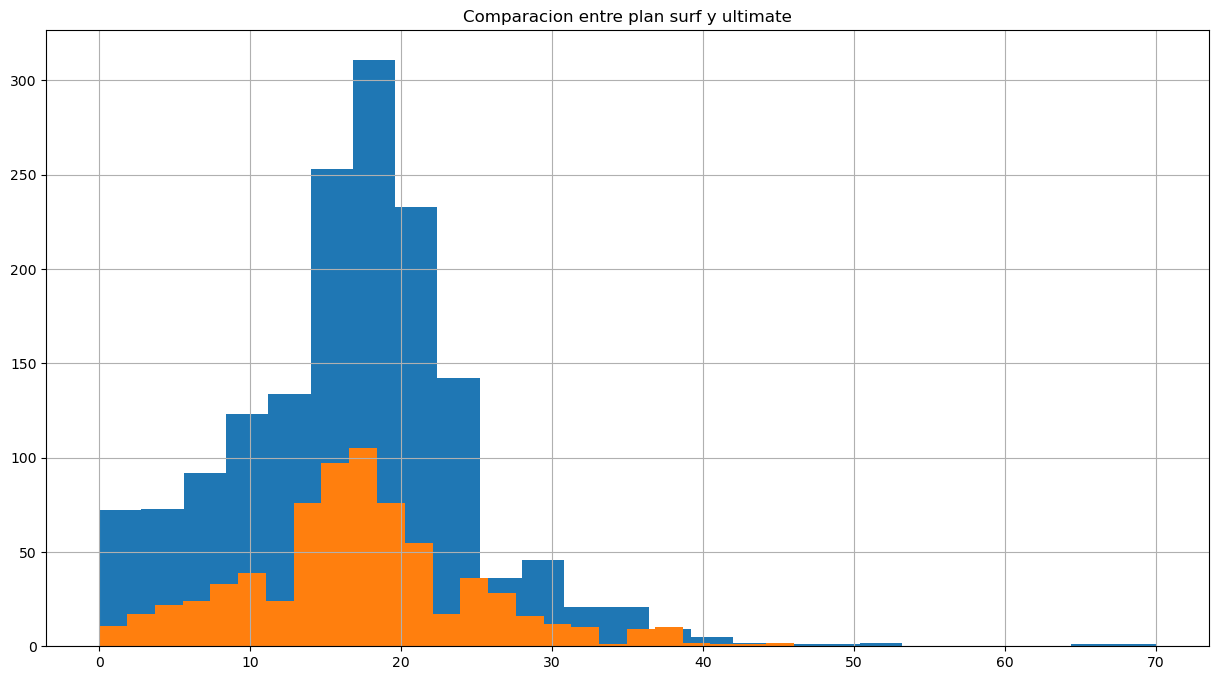

In [96]:
#Mostramos los histogramas superpuestos para ver la comparativa de los gb utilizados por plan
user_surf['total_gb'].hist(density=False,bins=25,figsize=(15,8))
user_ult['total_gb'].hist(density=False,bins=25,figsize=(15,8))
plt.title('Comparacion entre plan surf y ultimate')
plt.show()

Podemos observar de acuerdo a los datos que para el plan surf tenemos una **asimetria negativa**  donde la mayoria de usuarios usan de 16 a 19 gb; mientras que usuarios del plan ultimate con un **histograma simetrico** observamos que la mayoria de usuario usan de 16 a 18 gb

In [97]:
# Datos generales de los gb de ambos planes 
print('Datos de plan surf')
print(tr_surf['total_gb'].describe())
print('Datos de plan ultimate')
print(tr_ult['total_gb'].describe())

Datos de plan surf
count      12.000000
mean     2185.250000
std      1931.500506
min        10.000000
25%       536.250000
50%      1772.000000
75%      3460.000000
max      5800.000000
Name: total_gb, dtype: float64
Datos de plan ultimate
count      12.000000
mean     1038.416667
std       887.787798
min        29.000000
25%       312.500000
50%       849.000000
75%      1566.750000
max      2778.000000
Name: total_gb, dtype: float64


In [98]:
# Varianza de la cantidad total mensual de gb.
print('Varianza plan surf')
print(np.var(tr_surf['total_gb']))
print()
print('Varianza plan ultimate')
print(np.var(tr_ult['total_gb']))

Varianza plan surf
3419803.0208333335

Varianza plan ultimate
722486.576388889


In [99]:
# Media y la varianza de la duración mensual de sesiones.
print('La varianza y el promedio de duracion de cada secion al mes por tipo de plan')
display(inter.pivot_table(index='session_month',values='gb_used',columns='plan_name',aggfunc=('var','mean')))

La varianza y el promedio de duracion de cada secion al mes por tipo de plan


mean                 var          
plan_name          surf  ultimate      surf  ultimate
session_month                                        
1              0.317374  0.409451  0.088838  0.081636
2              0.347534  0.395579  0.066264  0.074422
3              0.365996  0.415291  0.077581  0.085130
4              0.352298  0.368584  0.072899  0.074986
5              0.350719  0.362162  0.072169  0.075805
6              0.349015  0.369741  0.072554  0.077526
7              0.360520  0.360958  0.073479  0.072482
8              0.362197  0.365228  0.072749  0.075169
9              0.355899  0.366376  0.072851  0.075430
10             0.356906  0.367057  0.071564  0.074278
11             0.351767  0.363360  0.072166  0.073853
12             0.354261  0.355661  0.073330  0.073063

Diagramas de caja para el plan surf, promedio por sesion


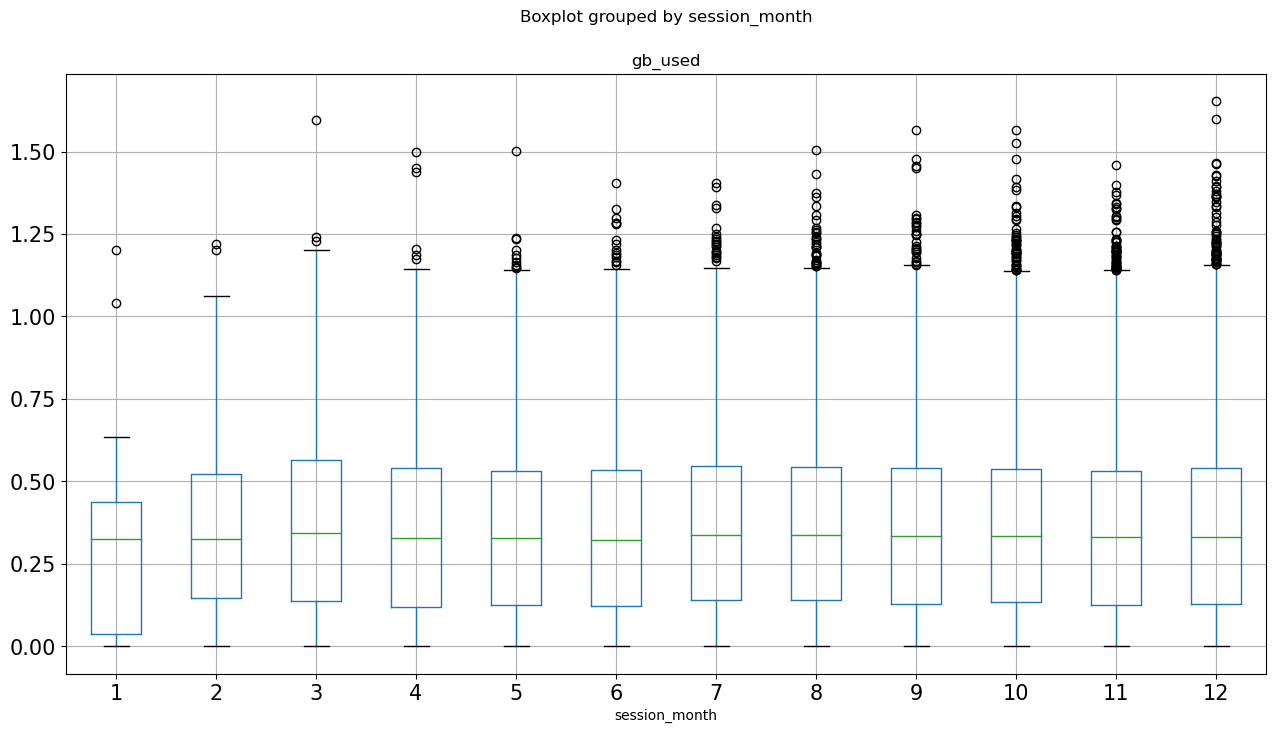

In [100]:
print('Diagramas de caja para el plan surf, promedio por sesion')
inter.query('plan_name == "surf"').boxplot(column='gb_used',by='session_month',figsize=(15,8),fontsize=15)
plt.show()

Diagramas de caja para el plan surf, promedio por sesion


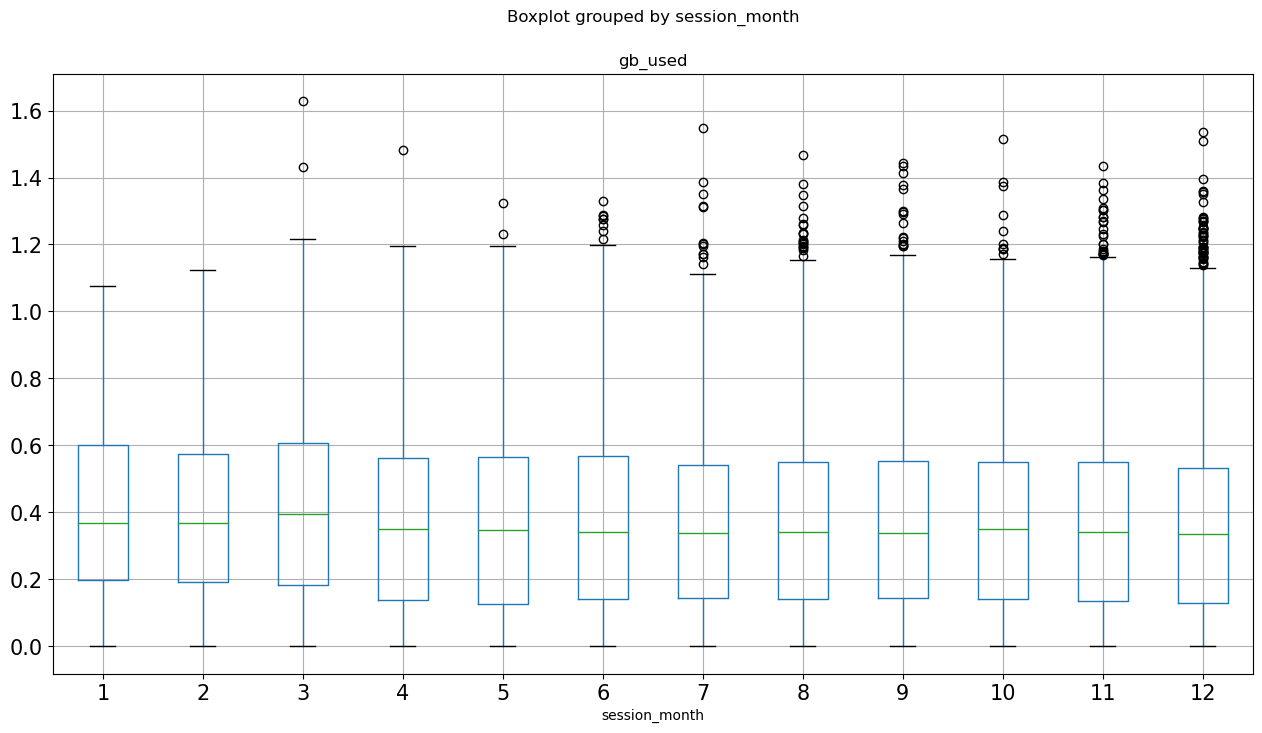

In [101]:
print('Diagramas de caja para el plan surf, promedio por sesion')
inter.query('plan_name == "ultimate"').boxplot(column='gb_used',by='session_month',figsize=(15,8),fontsize=15)
plt.show()

Como podemos observar, el consumo de internet en mucho mayor en los usuarios con planes surf, podemos observar un consumo 2:1 entre planes, es decir, se consume el doble de internet en el plan surf a partir del mes 4(abril), lo que podriamos pensar que es una desventaja para el usuario, y una ganancia para la empresa en cuanto ingresos, el cual comprobaremos mas adelante.

## Ingreso

In [102]:
tr.head()

,plan_name,month,%,age,call_over_price,gb_per_month_included,int_over,int_over_price,mb_per_month_included,messages_per_month_included,...,total_calls,total_gb,total_min,total_msg,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,user_id,calls_mean
1,surf,1,2.0000,105,0.00,30.0,0.0,0.0,30720,100,...,60.0,10.0,406.0,21.0,40,20,0.06,0.06,2404,6.766667
2,surf,2,15.4785,430,9.33,135.0,12.0,120.0,138240,450,...,366.0,110.0,2673.0,108.0,180,90,0.27,0.27,11338,7.303279
3,surf,3,52.8325,1109,16.26,345.0,58.0,580.0,353280,1150,...,1068.0,312.0,7590.0,351.0,460,230,0.69,0.69,29228,7.106742
4,surf,4,101.7765,2208,52.92,750.0,98.0,980.0,768000,2500,...,2444.0,611.0,17577.0,870.0,1000,500,1.50,1.50,62439,7.191899
5,surf,5,183.3685,3473,127.71,1155.0,199.0,1990.0,1182720,3850,...,4289.0,1087.0,30768.0,1849.0,1540,770,2.31,2.31,95348,7.173700


In [103]:
# Mostramos el total a pagar por mes y por plan
print('Total de pago por mes plan surf')
display(tr_surf[['month','to_pay']])
print('Total de pago por mes plan ultimate')
display(tr_ult[['month','to_pay']])

Total de pago por mes plan surf


,month,to_pay
1,1,40.00
2,2,309.57
3,3,1056.65
4,4,2035.53
5,5,3667.37
6,6,4779.80
7,7,7583.56
8,8,10356.85
9,9,11304.67
10,10,15504.83


Total de pago por mes plan ultimate


,month,to_pay
14,1,280.0
15,2,490.0
16,3,896.0
17,4,1533.0
18,5,2051.0
19,6,3367.0
20,7,4242.0
21,8,5173.0
22,9,6195.0
23,10,7665.0


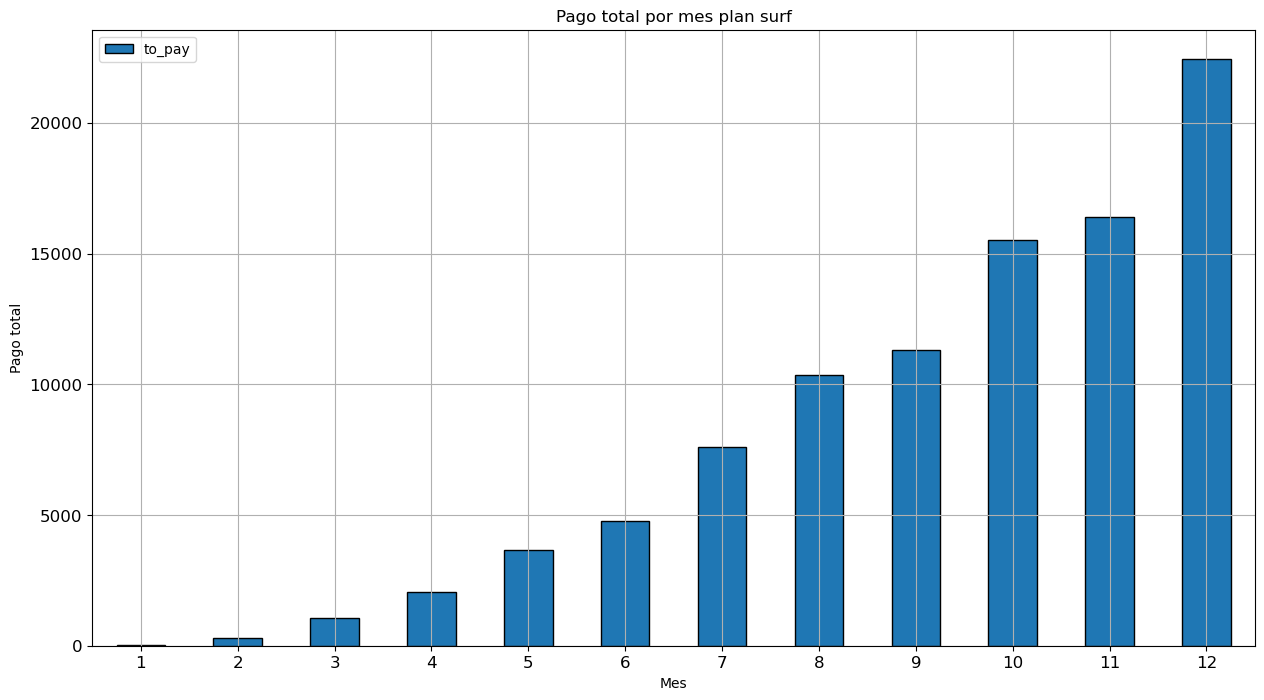

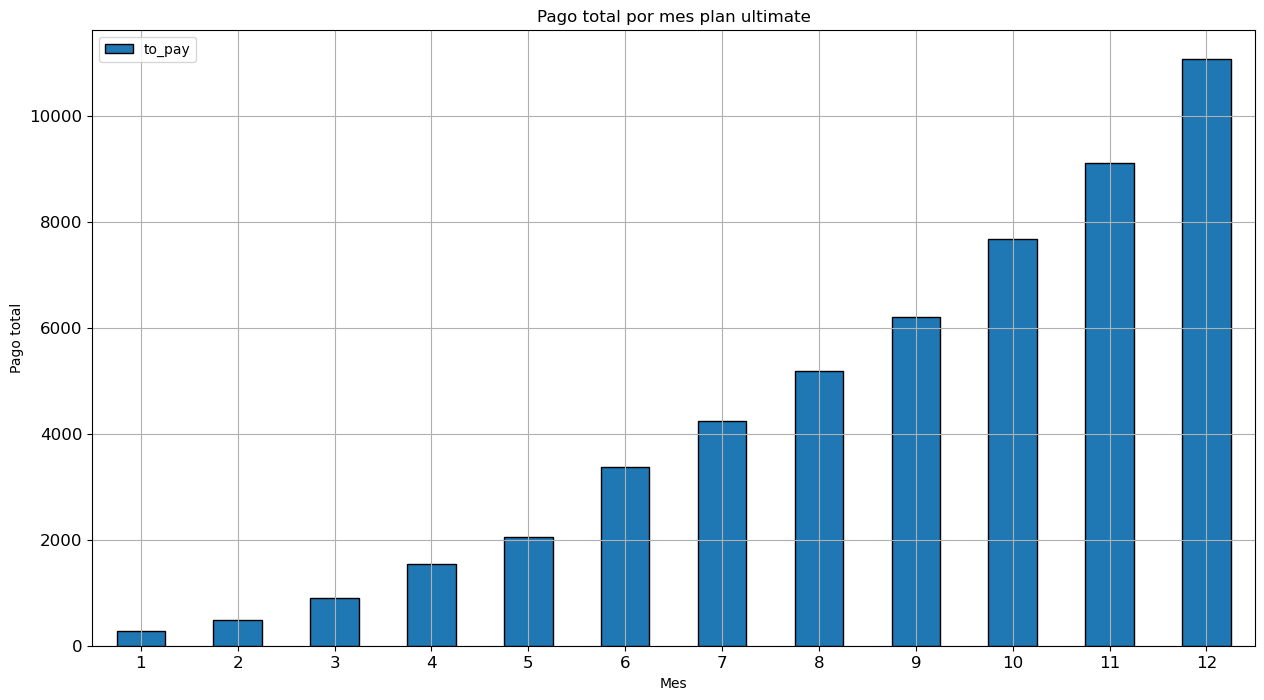

In [104]:
# Compara la cantidad a pagar por usuarios por plan
tr_surf.plot(x='month',
        y='to_pay',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Pago total por mes plan surf',
                                                ylabel='Pago total',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
tr_ult.plot(x='month',
        y='to_pay',
                                                kind='bar',
                                                figsize=(15,8),
                                                fontsize=12,
                                                title='Pago total por mes plan ultimate',
                                                ylabel='Pago total',
                                                xlabel='Mes',
                                                grid=True,
                                                edgecolor='black',
                                                rot=0)
plt.show()

Podemos observar que la cantidad de total de pago es el doble en los usuarios surf en comparacion con el  plan ultimate, esto quiere decir que el plan surf tiene mas entrada de dinero hacia la empresa.

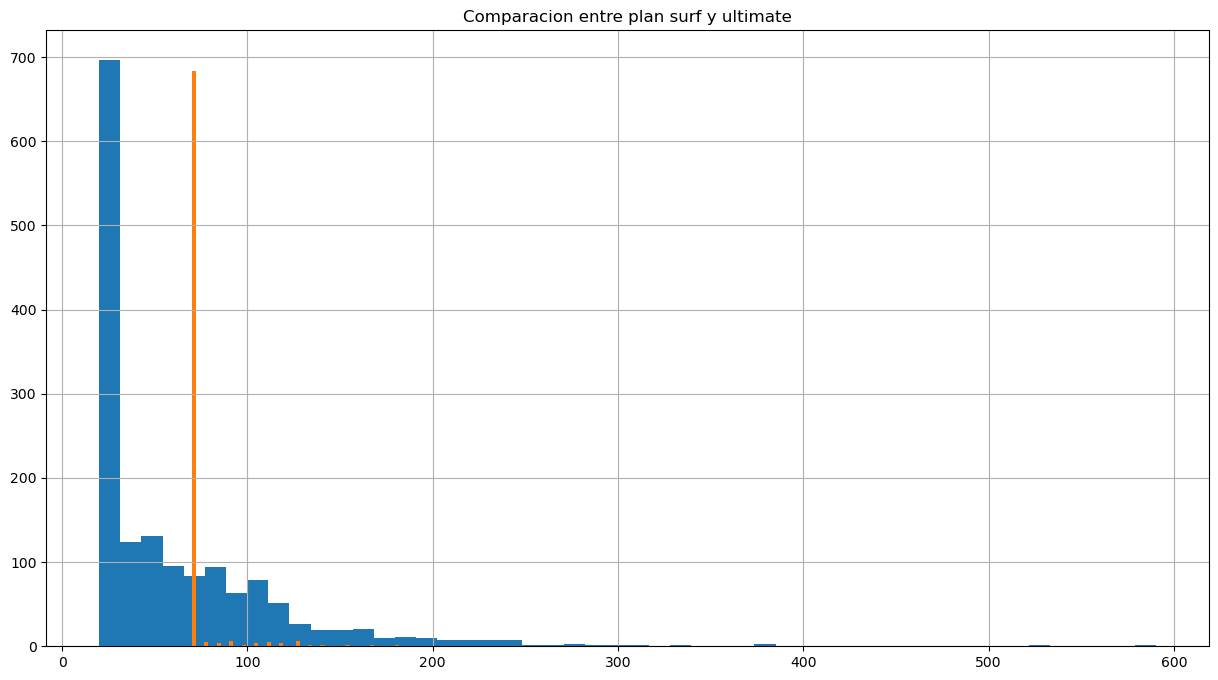

In [105]:
#Mostramos los histogramas superpuestos para ver la comparativa
user_surf['to_pay'].hist(density=False,bins=50,figsize=(15,8))
user_ult['to_pay'].hist(density=False,bins=50,figsize=(15,8))
plt.title('Comparacion entre plan surf y ultimate')
plt.show()

Podemos observar que para el plan surf, la mayoria de usuarios paga entre 20 y 50 usd, teeniendo  un pico en pagos totales de 20 a 30usd, sin embargo, podemos observar que los pagos en plan surf son muy variantes, es decir llegan a pagar desde 20 usd hasta mas de 200usd en algunos casos, en cambio los usurios de plan ultimate se mantienen en pagos de 70 usd y pocos valores en los que algunos clientes llegan a pagar mas de esta cantidad. 

In [106]:
print('Media de pago contra pago normal de plan surf')
display(user_surf[['usd_monthly_pay','to_pay']].mean())

print('Media de pago contra pago normal de plan ultimate')
display(user_ult[['usd_monthly_pay','to_pay']].mean())


Media de pago contra pago normal de plan surf


usd_monthly_pay    20.000000
to_pay             60.551729
dtype: float64

Media de pago contra pago normal de plan ultimate


usd_monthly_pay    70.000000
to_pay             72.301105
dtype: float64

In [107]:
# Datos generales de los pagos de ambos planes 
print('Datos de plan surf')
print(tr_surf['to_pay'].describe())
print('Datos de plan ultimate')
print(tr_ult['to_pay'].describe())

Datos de plan surf
count       12.000000
mean      7957.598333
std       7308.944540
min         40.000000
25%       1790.810000
50%       6181.680000
75%      12354.710000
max      22437.140000
Name: to_pay, dtype: float64
Datos de plan ultimate
count       12.000000
mean      4338.833333
std       3572.746329
min        280.000000
25%       1373.750000
50%       3804.500000
75%       6562.500000
max      11067.000000
Name: to_pay, dtype: float64


In [108]:
# Varianza de la cantidad total a pagar.
print('Varianza plan surf')
print(np.var(tr_surf['to_pay']))
print()
print('Varianza plan ultimate')
print(np.var(tr_ult['to_pay']))

Varianza plan surf
48968947.76556388

Varianza plan ultimate
11700806.63888889


In [109]:
# Media y la varianza del pago de cada usuario por mes.
print('La varianza y el promedio de duracion de cada secion al mes por tipo de plan')
display(plan_db.pivot_table(index='month',values='to_pay',columns='plan_name',aggfunc=('var','mean')))

La varianza y el promedio de duracion de cada secion al mes por tipo de plan


mean                     var            
plan_name       surf   ultimate         surf    ultimate
month                                                   
0.0        20.000000  70.000000     0.000000    0.000000
1.0        20.000000  70.000000     0.000000    0.000000
2.0        34.396667  70.000000   428.276100    0.000000
3.0        45.941304  74.666667  1512.023512  145.515152
4.0        40.710600  73.000000  1198.958402  120.400000
5.0        47.628182  70.724138  1967.540055   15.206897
6.0        49.276289  71.638298  1988.914046   75.018501
7.0        62.674050  71.898305  2943.388409  104.472238
8.0        63.931173  72.859155  3587.494901  154.808451
9.0        58.271495  72.034884  2260.644980   75.939945
10.0       65.421224  72.311321  3198.242612  169.606918
11.0       58.004276  71.708661  2494.182230   94.668416
12.0       70.557044  73.291391  4604.410868  212.861192

Como observamos en las tablas anteriores el consumo en el ambito de llamadas, mensajes y consumo de internet es aprox el doble en casi todos los meses, comenzando de abril, a partir de asumir que de abril a diciembre se consume el doble por parte de los usuarios con plan surf respecto a los usuarios con plan ultimate, y llegamos a dos conclusiones rapidamente:
1. Los usuarios del plan ultimate rara vez tienen un exceso de uso respecto a su plan, y lo podemos ver a la hora del pago, siendo que el pago normal es de 70usd y el promedio de pago es de 73usd, en cambio los usuarios del plan ultimate estan sobrepasando el limite de su plan lo que repercute a la hora del pago siendo que terminan pagando hasta un 240% mas de lo que deberian pagar sin excesos. 
2. Como mencionamos el consumo de los usuarios con plan surf es el doble de los del plan ultimate, teniendo una media de pago de 67usd, si cambiaran de plan a ultimate estarian cubiertos sin tener cargos extra por excesos e incluso utilizar mas el servicio de llamadas y mensajes de lo que utilizan actualmente sin cargos extra, solo tendrian que tener un uso moderado en cuestion de internet para no sobrepasar el limite.

## Probar las hipótesis estadísticas.

In [110]:
# Prueba las hipótesis
# H0 EL promedio de pago de los usuarios de plan surf es igual al monto de pago base del plan ultimate.
# H1 el promedio de pago  no es igual
tpay_surf = tr.query('plan_name == "surf"')
tpay_ult = tr.query('plan_name == "ultimate"')
# Muestra del pago de los usuarios plan surf
tpay_surf_array = tpay_surf['to_pay']
# Muestra del pago de los usuarios plan ultimate
tpay_ult_array = tpay_ult['to_pay']

alpha = 0.05

results = st.ttest_ind(tpay_surf_array, tpay_ult_array)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value: 0.1376061411901091
No rechazamos la hipótesis nula


Como podemos ver, no rechazamos la hipotesis de que los usuarios del plan surf pagan igual a un usuario de plan ultimate, ya que tenemos una probabilidad del 13% que los usuarios paguen igual a los usuarios del plan ultimate, y podemos dar esa conclusion ya que como vimos arriba, la media de pago es de 60 usd de usuarios de plan surf contra 72 usd de usuarios de plan ultimate. 

In [111]:
# Veamos que valores contiene las ciudades
plan_db['city'].sort_values().unique()

array(['Albany-Schenectady-Troy, NY MSA', 'Albuquerque, NM MSA',
       'Atlanta-Sandy Springs-Roswell, GA MSA',
       'Austin-Round Rock-Georgetown, TX MSA', 'Bakersfield, CA MSA',
       'Baltimore-Columbia-Towson, MD MSA', 'Baton Rouge, LA MSA',
       'Birmingham-Hoover, AL MSA', 'Boston-Cambridge-Newton, MA-NH MSA',
       'Bridgeport-Stamford-Norwalk, CT MSA',
       'Buffalo-Cheektowaga, NY MSA', 'Cape Coral-Fort Myers, FL MSA',
       'Charleston-North Charleston, SC MSA',
       'Charlotte-Concord-Gastonia, NC-SC MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA',
       'Cincinnati, OH-KY-IN MSA', 'Cleveland-Elyria, OH MSA',
       'Colorado Springs, CO MSA', 'Columbia, SC MSA', 'Columbus, OH MSA',
       'Dallas-Fort Worth-Arlington, TX MSA', 'Dayton-Kettering, OH MSA',
       'Denver-Aurora-Lakewood, CO MSA',
       'Detroit-Warren-Dearborn, MI MSA', 'El Paso, TX MSA',
       'Fresno, CA MSA', 'Grand Rapids-Kentwood, MI MSA',
       'Greensboro-High Point, NC MSA',
    

In [112]:
# Prueba las hipótesis
# H0 Los ingresos de usuarios de NY-NJ es igual al ingreso de las demas ciudades.
# H1 El ingreso de usuario de NY-NJ no es igual al ingreso de las demas ciudades.
tpay_ny_nj = plan_db.query('city == "New York-Newark-Jersey City, NY-NJ-PA MSA"')
tpay_cities = plan_db.query('city != "New York-Newark-Jersey City, NY-NJ-PA MSA"')
# Muestra del pago de los usuarios de New York-Newark-Jersey City, NY-NJ-PA MSA
tpay_ny_nj_array = tpay_ny_nj['to_pay']
# Muestra del pago de los usuarios que no son de New York-Newark-Jersey City, NY-NJ-PA MSA
tpay_cities_array = tpay_cities['to_pay']

alpha = 0.05

results = st.ttest_ind(tpay_ny_nj_array, tpay_cities_array)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value: 0.04974528277407551
Rechazamos la hipótesis nula


Como podemos ver rechazamos la hipotesis de que los usuarios de NY-NJ pagan igual a los usuarios de otras ciudades, por lo que el pago es distinto en un 4.97% aproximadamente. 

## Conclusión general

* Como bien empezamos a cargar y revisar tabla por tabla para ver que datos contienen, que tipos de datos son, que tipos de datos podemos relacionar entre las diferentes tablas y que datos nos puedes ayudar a aportar algun dato entre estas para realizar un analisis.
* Una vez reparados los datos y convertidos a los datos correctos, podemos agregar columnas que nos ayuden a relacionar las tablas entre si, como lo es el caso del mes, user_id, y el tipo de plan.
* Una vez entendiendo como funcionan los planes podemos hacer un resumen y redondedos acerca del comportamiento de los usuarios y del uso de los planes.
* Realizamos una tabla general en la que ponemos las cantidades totales por cada servicio, llamadas, mensajes y uso de internet, esto para un analisis mas facil y rapido a la hora de obtener ciertos resultados que engloben los meses o cierto tipo de usuarios.
* Pudimos observar que el comportamiento de los usuarios del plan surf es usar aproximadamente el doble de servicios que los usuarios del plan ultimate, por lo que hay un comportamiento regular.
* Pudimos calcular el costo por cada mes, observando que el promedio de pago de los usuarios tipo surf es de 60USD usando el doble de servicios en comparacion al plan ultimate, siendo que aun ocupando esa cantidad de servicios aun estan por debajo del pago de un plan ultimate regular.
* De acuerdo a las hipotesis que hicimos pudimos obervar:
 * El pago de los usuarios del plan surf  es similar al de los usuarios del plan ultimate ya que tenemos una probabilidad de 13% que un usuario de plan surf pague lo mismo que un usuario de plan ultimate, por lo que habria que considerar si como empresa nos conviene modificar las tarifas para al menos garantizar que  el usuario que tenga un consumo de servicios alto y el pago sea alrededor de los 60 sea mejor que contrate el plan ultimate y asegurar por los menos esos 10 usd extra.
 * El pago de los usuarios de la ciudad NY-NJ no es similar al de las demas ciudades de la muestra por alrededor del 4%.